# MetaboAnalystR Workflow

This notebook demonstrates a complete metabolomics data analysis workflow using MetaboAnalystR. It covers:

1. Data preparation and loading
2. Data processing and normalization
3. Statistical analysis (PCA)
4. Visualization and result export

Make sure you've successfully run `00_setup_and_validation.ipynb` before starting this workflow.

## 1. Setup and Initialization

Load required libraries and set up the working environment.

In [ ]:
# Initialize working directory
project_root <- normalizePath("..")
setwd(project_root)

# Helper function for path management
get_path <- function(subdir) {
    file.path(project_root, subdir)
}

# Load required libraries
library(MetaboAnalystR)
cat(sprintf("MetaboAnalystR v%s loaded\n", packageVersion("MetaboAnalystR")))

# Create processing log function
log_process <- function(message, log_file = file.path(get_path("data/processed"), "processing_log.txt")) {
    timestamp <- format(Sys.time(), "%Y-%m-%d %H:%M:%S")
    log_entry <- sprintf("[%s] %s\n", timestamp, message)
    cat(log_entry)
    cat(log_entry, file = log_file, append = TRUE)
}

MetaboAnalystR 4.0.0 initialized Successfully !
https://github.com/xia-lab/MetaboAnalystR



MetaboAnalystR v4.0.0 loaded


## 2. Create Example Dataset

Generate a sample metabolomics dataset for demonstration.

In [2]:
# Create sample metabolomics data
set.seed(123)  # For reproducibility

# Generate example data
n_samples <- 12  # 6 control, 6 treatment
n_metabolites <- 50

# Create sample names and groups
sample_names <- paste0("Sample_", 1:n_samples)
groups <- rep(c("Control", "Treatment"), each = n_samples/2)

# Generate metabolite data with biological variation
metabolite_data <- matrix(rnorm(n_samples * n_metabolites, mean = 10, sd = 2), 
                         nrow = n_samples)

# Add treatment effect to some metabolites
effect_metabolites <- 1:10  # First 10 metabolites show treatment effect
treatment_samples <- (n_samples/2 + 1):n_samples
metabolite_data[treatment_samples, effect_metabolites] <- 
    metabolite_data[treatment_samples, effect_metabolites] + 2

# Create metabolite names
metabolite_names <- paste0("Metabolite_", 1:n_metabolites)

# Create data frame
test_data <- data.frame(
    Sample = sample_names,
    Group = groups,
    metabolite_data
)
names(test_data)[3:ncol(test_data)] <- metabolite_names

# Save to data directory
data_file <- file.path(get_path("data"), "test_metabolites.csv")
write.csv(test_data, data_file, row.names = FALSE)
log_process(sprintf("Created test dataset with %d samples and %d metabolites", n_samples, n_metabolites))

# Display data preview
head(test_data[, 1:8])

[2024-11-04 02:54:28] Created test dataset with 12 samples and 50 metabolites


,Sample,Group,Metabolite_1,Metabolite_2,Metabolite_3,Metabolite_4,Metabolite_5,Metabolite_6
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Sample_1,Control,8.879049,10.801543,8.749921,11.107835,11.559930,10.759279
2,Sample_2,Control,9.539645,10.221365,6.626613,9.876177,9.833262,8.995353
3,Sample_3,Control,13.117417,8.888318,11.675574,9.388075,10.506637,9.333585
4,Sample_4,Control,10.141017,13.573826,10.306746,9.239058,9.942906,7.962849
5,Sample_5,Control,10.258575,10.995701,7.723726,8.610586,9.914259,7.856418
6,Sample_6,Control,13.430130,6.066766,12.507630,9.584165,12.737205,10.607057


## 3. Data Processing Pipeline

Process the metabolomics data through standard preprocessing steps.

In [3]:
# Initialize MetaboAnalystR
mSet <- InitDataObjects("pktable", "stat", FALSE)
log_process("Initialized MetaboAnalystR objects")

# Read data
mSet <- Read.TextData(mSet, data_file, "rowu", "disc")
log_process("Loaded data file")

# Sanity check
mSet <- SanityCheckData(mSet)
log_process("Completed sanity check")

# Save raw data view
raw_data <- mSet$dataSet$norm
write.csv(raw_data, 
          file.path(get_path("data/processed"), "raw_dataview.csv"),
          row.names = TRUE)

# Preprocessing steps
# 1. Replace minimum values
mSet <- ReplaceMin(mSet)
log_process("Replaced minimum values")

# 2. Prepare for normalization
mSet <- PreparePrenormData(mSet)
log_process("Prepared data for normalization")

# 3. Perform normalization
# Using log transformation and auto-scaling
mSet <- Normalization(mSet, "log", "auto", "MeanCenter", ratio = FALSE)
log_process("Completed normalization")

# Save normalized data
norm_data <- mSet$dataSet$norm
write.csv(norm_data, 
          file.path(get_path("data/processed"), "normalized_data.csv"),
          row.names = TRUE)

# Display normalization summary
cat("\nNormalization Summary:\n")
cat("Samples:", nrow(norm_data), "\n")
cat("Metabolites:", ncol(norm_data), "\n")

Starting Rserve:
 /home/ubuntu/miniconda3/envs/metaboanalystr/lib/R/bin/R CMD /home/ubuntu/miniconda3/envs/metaboanalystr/lib/R/library/Rserve/libs//Rserve --no-save 

[1] "MetaboAnalyst R objects initialized ..."
[2024-11-04 02:55:12] Initialized MetaboAnalystR objects
[2024-11-04 02:55:12] Loaded data file
 [1] "Successfully passed sanity check!"                                                                                
 [2] "Samples are not paired."                                                                                          
 [3] "2 groups were detected in samples."                                                                               
 [4] "Only English letters, numbers, underscore, hyphen and forward slash (/) are allowed."                             
 [5] "<font color=\"orange\">Other special characters or punctuations (if any) will be stripped off.</font>"            
 [6] "All data values are numeric."                                                  

## 4. Principal Component Analysis (PCA)

Perform PCA and create visualizations.

[2024-11-04 02:55:50] Completed PCA analysis
[2024-11-04 02:55:50] Generated PCA plots


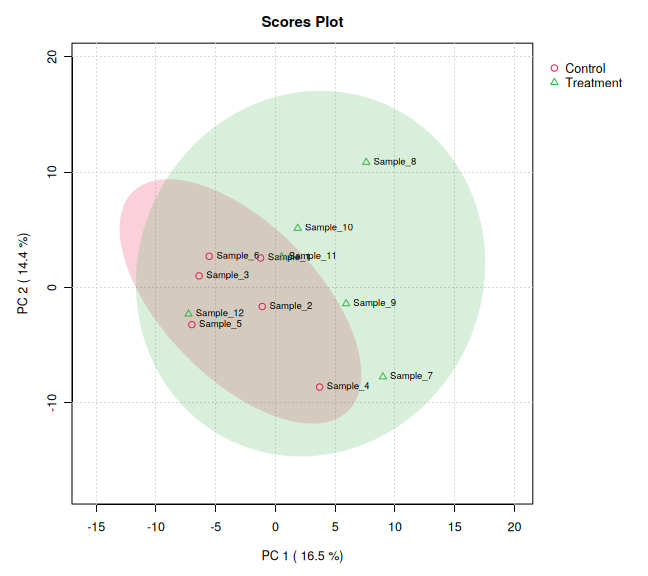

PCA plot displayed


In [4]:
# Perform PCA
mSet <- PCA.Anal(mSet)
log_process("Completed PCA analysis")

# Save PCA results
write.csv(mSet$analSet$pca$scores,
          file.path(get_path("results"), "pca_scores.csv"),
          row.names = TRUE)
write.csv(mSet$analSet$pca$loadings,
          file.path(get_path("results"), "pca_loadings.csv"),
          row.names = TRUE)

# Create PCA plot
plot_file <- file.path(get_path("plots"), "pca_scores_2d")
mSet <- PlotPCA2DScore(mSet,
                       plot_file,
                       "png",
                       72,
                       width = NA,
                       1,
                       2)
log_process("Generated PCA plots")

# Display PCA plot
library(IRdisplay)
png_file <- paste0(plot_file, "dpi72.png")
if (file.exists(png_file)) {
    display_png(file = png_file)
    cat("PCA plot displayed\n")
} else {
    cat("PCA plot file not found at:", png_file, "\n")
}

## 5. Save Analysis State

Save the complete analysis state and results.

In [6]:
# Create temp directory if it doesn't exist
temp_dir <- get_path("data/temp")
if (!dir.exists(temp_dir)) {
    dir.create(temp_dir, recursive = TRUE)
    log_process("Created temp directory for MetaboAnalystR files")
}

# List of known MetaboAnalystR temp files to handle
temp_files <- c(
    # QS files
    "complete_norm.qs",
    "data_orig.qs",
    "data_proc.qs",
    "prenorm.qs",
    "preproc.qs",
    "row_norm.qs",
    # CSV files
    "pca_loadings.csv",
    "pca_score.csv",
    "raw_dataview.csv"
)

# Move temp files to temp directory
for (file in temp_files) {
    if (file.exists(file)) {
        file.rename(
            file,
            file.path(temp_dir, file)
        )
        log_process(sprintf("Moved %s to temp directory", file))
    }
}

# Save complete analysis state
saveRDS(mSet, file = file.path(get_path("results"), "complete_analysis.rds"))

# Save session information
writeLines(capture.output(sessionInfo()),
          file.path(get_path("results"), "session_info.txt"))

log_process("Saved complete analysis state and session information")

# Create analysis summary
summary <- c(
    "# Metabolomics Analysis Summary",
    paste("Date:", Sys.Date()),
    "",
    "## Dataset Information:",
    paste("Number of samples:", nrow(norm_data)),
    paste("Number of metabolites:", ncol(norm_data)),
    paste("Groups:", paste(unique(groups), collapse = ", ")),
    "",
    "## Processing Steps:",
    "1. Data loading and sanity check",
    "2. Minimum value replacement",
    "3. Log transformation",
    "4. Auto-scaling",
    "5. PCA analysis",
    "",
    "## Output Files:",
    "### Results Directory:",
    "- Analysis state: results/complete_analysis.rds",
    "- Analysis summary: results/analysis_summary.txt",
    "- Session information: results/session_info.txt",
    "",
    "### Processed Data Directory:",
    "- Normalized data: data/processed/normalized_data.csv",
    "",
    "### Plots Directory:",
    "- PCA plot: plots/pca_scores_2d.png",
    "",
    "### Temporary Files (data/temp):",
    paste("-", temp_files)
)

writeLines(summary, file.path(get_path("results"), "analysis_summary.txt"))
log_process("Created analysis summary")

# Cleanup function for later use
cleanup_temp <- function() {
    temp_files <- list.files(temp_dir, full.names = TRUE)
    unlink(temp_files)
    log_process("Cleaned up temporary files")
}

cat("\nAnalysis Complete!\n")
cat("Results have been saved to the following directories:\n")
cat("- Processed data: data/processed/\n")
cat("- Plots: plots/\n")
cat("- Results: results/\n")
cat("- Temporary files: data/temp/\n")
cat("\nTo clean up temporary files later, use: cleanup_temp()\n")

[2024-11-04 02:58:58] Created temp directory for MetaboAnalystR files
[2024-11-04 02:58:58] Moved complete_norm.qs to temp directory
[2024-11-04 02:58:58] Moved data_orig.qs to temp directory
[2024-11-04 02:58:58] Moved data_proc.qs to temp directory
[2024-11-04 02:58:58] Moved prenorm.qs to temp directory
[2024-11-04 02:58:58] Moved preproc.qs to temp directory
[2024-11-04 02:58:58] Moved row_norm.qs to temp directory
[2024-11-04 02:58:58] Moved pca_loadings.csv to temp directory
[2024-11-04 02:58:58] Moved pca_score.csv to temp directory
[2024-11-04 02:58:58] Moved raw_dataview.csv to temp directory
[2024-11-04 02:58:59] Saved complete analysis state and session information
[2024-11-04 02:58:59] Created analysis summary

Analysis Complete!
Results have been saved to the following directories:
- Processed data: data/processed/
- Plots: plots/
- Results: results/
- Temporary files: data/temp/

To clean up temporary files later, use: cleanup_temp()


## Analysis Complete

You have successfully:
1. Created and processed a metabolomics dataset
2. Performed data normalization
3. Conducted PCA analysis
4. Generated visualizations
5. Saved all results and analysis state

### Next Steps:
1. Replace the example data with your own metabolomics data
2. Adjust processing parameters as needed
3. Explore additional analyses:
   - Statistical tests
   - Pathway analysis
   - Biomarker identification

### Resources:
- MetaboAnalystR documentation: https://www.metaboanalyst.ca/docs/RTutorial.xhtml
- Additional examples: See `docs/` directory
- Troubleshooting: See `docs/troubleshooting.md`